## Curve fiting of MD of CP data

In [3]:
#
library(ggplot2)

#install.packages("drc", dependencies = TRUE)

devtools::install_github("jessica-ewald/fastbmdR")

library(fastbmdR)
library(dplyr)
library(knitr)
library(ggforce)
library(arrow)


Using GitHub PAT from the git credential store.

Skipping install of 'fastbmdR' from a github remote, the SHA1 (b3681861) has not changed since last install.
  Use `force = TRUE` to force installation



In [4]:
## loading parqet file of already ready mahalanobis distances between the compounds and DMSO centroids 

md_data= read_parquet("./outputs/CP_distances.parquet")

md_data = data.frame(md_data)

In [ ]:
## computing the BMD for the mahalanobis distance de CP data

md_data$Metadata_assay_conc_uM[is.na(md_data$Metadata_assay_conc_uM)] <- 0
md_data$Metadata_Annotation[is.na(md_data$Metadata_Annotation)] <- 'DMSO'


df <- md_data[md_data$Metadata_Annotation != "JUMP control",]

#df <- df[df$Metadata_Annotation != "NA", ]

models <- c("Exp2", "Exp3", "Exp4", "Exp5", "Poly2", "Lin", "Power", "Hill")

ncpus <- 1

unique_compounds <- unique(df$Metadata_Compound)

feat_cols <- colnames(md_data)[!grepl("Metadata", colnames(md_data))]
res <- list()
gene_table <- list()

all_bmd_pass <- data.frame()

for (compound in unique_compounds) {
  
  
  compound_data <- df[df$Metadata_Compound %in% c(compound, "DMSO"), ]
  compound_data$Metadata_assay_conc_uM[is.na(compound_data$Metadata_assay_conc_uM)] <- 0


  dose <- compound_data$Metadata_assay_conc_uM
  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])
  
  rank_dose = unique(dose) %>% sort(. , decreasing = TRUE)
  dose_spacing = abs(log10(rank_dose[2]/rank_dose[1]))
  
  dose_shift = abs(min(dose_log)) + dose_spacing
  dose_shifted = dose_log
  dose_shifted[dose_shifted != 0] = dose_shifted[dose_shifted != 0] + dose_shift
  #print(unique(compound_data$Metadata_assay_conc_uM))
  if (length(unique(compound_data$Metadata_assay_conc_uM)) > 2) {  
    
    print(paste("Processing compound:", compound))  
    dose <- dose_shifted
    
    compound_mat <- t(compound_data[, feat_cols])  
    min_val = abs(min(compound_mat, na.rm=TRUE))  
    add_min = min_val + 0.1 * min_val  
    mat_new = compound_mat + add_min  
    
    if (length(dose) == ncol(mat_new)) {  
      tryCatch({
        fit_obj <- PerformCurveFitting(data = mat_new, dose = dose, ncpus = ncpus, models = models)
        fit_obj <- FilterDRFit(fit_obj, lof.pval = 0.1, filt.var = "AIC.model")
        fit_obj <- PerformBMDCalc(fit_obj, ncpus = ncpus, num.sds = 2, bmr.method = "sample.mean", log10.dose = TRUE)
        
        bmd_res <- fit_obj$bmd_res
        bmd_pass <- bmd_res[bmd_res$all.pass, ]
        fit_obj$bmd_pass <- bmd_pass

        res[[compound]] <- fit_obj
        
        if (nrow(bmd_pass) > 0) {
          bmd_pass$compound_name <- compound
          all_bmd_pass <- rbind(all_bmd_pass, bmd_pass) 
        }
      }, error = function(e) {
        print(paste("Error with compound:", compound, "- ignoring this compound"))
      })
    }
  }  
}

In [6]:
## calculating the bmd values at real concentration

all_bmd_pass$Concentration <- NA
all_bmd_pass$Concentration_L <- NA
all_bmd_pass$Concentration_U <- NA

for (i in 1:nrow(all_bmd_pass)) {
  compound <- all_bmd_pass$compound_name[i]
  bmd <- all_bmd_pass$bmd[i]
  bmdl <- all_bmd_pass$bmdl[i]
  bmdu <- all_bmd_pass$bmdu[i]
  
  compound_data <- df[df$Metadata_Compound == compound,]
  dose <- compound_data$Metadata_assay_conc_uM

  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])
  
  rank_dose <- unique(dose)
  rank_dose <- sort(rank_dose, decreasing = TRUE)
  
  if (length(rank_dose) > 1) {
    dose_spacing <- abs(log10(rank_dose[2] / rank_dose[1]))
  } else {
    dose_spacing <- 1
  }
  
  dose_shift <- abs(min(dose_log, na.rm = TRUE)) + dose_spacing
  
  all_bmd_pass$Concentration[i] <- 10^(bmd - dose_shift)
  all_bmd_pass$Concentration_L[i] <- 10^(bmdl - dose_shift)
  all_bmd_pass$Concentration_U[i] <- 10^(bmdu - dose_shift)
}



In [ ]:
## 
list_plot <- list()  

for (i in 1:nrow(all_bmd_pass)) {  
  tryCatch({
    gene_id <- all_bmd_pass$gene.id[i]
    compound <- all_bmd_pass$compound_name[i]
    
    temp <- plot_bmd_curve(gene_id, res[[compound]], return_type = "plot.data")
    
    temp$protein <- gene_id
    temp$compound <- compound
    #temp$category <- all_bmd_pass$Metadata_Categories[i]
    temp$bmd <- all_bmd_pass$bmd[i]
    temp$bmd_l <- all_bmd_pass$bmdl[i]
    temp$bmd_u <- all_bmd_pass$bmdu[i]
    temp$Concentration <- all_bmd_pass$Concentration[i]
    temp$Concentration_L <- all_bmd_pass$Concentration_L[i]
    temp$Concentration_U <- all_bmd_pass$Concentration_U[i]
    
    list_plot[[i]] <- temp
  }, error = function(e) {
    message(sprintf("Error for gene_id %s and compound %s : %s", gene_id, compound, e$message))
  })
}

final_df_md <- do.call(rbind, list_plot)


kable(head(final_df_md))


In [9]:
kable(head(final_df_md))
print(unique(final_df_md$compound))



|  x| Observations|      f_x|protein         |compound      |      bmd|    bmd_l|    bmd_u| Concentration| Concentration_L| Concentration_U|
|--:|------------:|--------:|:---------------|:-------------|--------:|--------:|--------:|-------------:|---------------:|---------------:|
|  0|       6.8927| 6.529112|Cells_AreaShape |Actinomycin D | 2.700288| 2.396787| 3.013568|      2.541034|        1.263309|        5.227458|
|  0|       6.5367| 6.529112|Cells_AreaShape |Actinomycin D | 2.700288| 2.396787| 3.013568|      2.541034|        1.263309|        5.227458|
|  0|       6.3407| 6.529112|Cells_AreaShape |Actinomycin D | 2.700288| 2.396787| 3.013568|      2.541034|        1.263309|        5.227458|
|  0|       6.1517| 6.529112|Cells_AreaShape |Actinomycin D | 2.700288| 2.396787| 3.013568|      2.541034|        1.263309|        5.227458|
|  0|       5.6677| 6.529112|Cells_AreaShape |Actinomycin D | 2.700288| 2.396787| 3.013568|      2.541034|        1.263309|        5.227458|
|  0|      

 [1] "Actinomycin D"                          
 [2] "Calcipotriol (hydrate)"                 
 [3] "Treprostinil"                           
 [4] "Cucurbitacin I"                         
 [5] "FCCP"                                   
 [6] "CLIOQUINOL"                             
 [7] "Bevirimat"                              
 [8] "Staurosporine"                          
 [9] "Fluazinam"                              
[10] "MUPIROCIN"                              
[11] "Triamcinolone acetonide"                
[12] "Ethoxyquin"                             
[13] "Cycloheximide"                          
[14] "5,6-benzoflavone"                       
[15] "Rifampicin"                             
[16] "Colistin Methanesulfonate (sodium salt)"
[17] "Amperozide"                             
[18] "5,8,11-Eicosatriynoic acid"             
[19] "Nedocromil (sodium salt)"               
[20] "Berberine chloride"                     
[21] "Aminodarone Hydrochloride"              


In [ ]:
## we now plot the bmd curves for each compound and protein and save them in a pdf file

## NO NEED TO RE-RUN

n_per_page <- 9  


final_df_md$compound_protein <- paste(final_df_md$compound, final_df_md$protein, sep = " - ")


plot_groups <- unique(final_df_md$compound_protein)
n_pages <- ceiling(length(plot_groups) / n_per_page)


pdf_file <- "./figures/bmd_curves_MD_CP_data.pdf"
pdf(pdf_file, width = 15, height = 10)

for (i in 1:n_pages) {
  tryCatch({
    p <- ggplot(final_df_md, aes(x = x, y = Observations)) +
      geom_point(show.legend = FALSE) +
      geom_line(aes(y = f_x), show.legend = FALSE) +

      geom_vline(aes(xintercept = bmd), linetype = "solid", color = "red") +  
      geom_vline(aes(xintercept = bmd_l), linetype = "dashed", color = "red") + 
      geom_vline(aes(xintercept = bmd_u), linetype = "dashed", color = "red") +  
      facet_wrap_paginate(~ compound_protein, ncol = 3, nrow = 3, page = i, scales = "free_y") +
      
      labs(title = sprintf("BMD curves of MD/ CP data", i),
           x = "Concentration",
           y = "Observation") +
      theme_bw() +
      theme(strip.text = element_text(size = 8))
    
    print(p) 
  }, error = function(e) {
    message(sprintf("Error in the page %d : %s", i, e$message))
  })
}
dev.off()


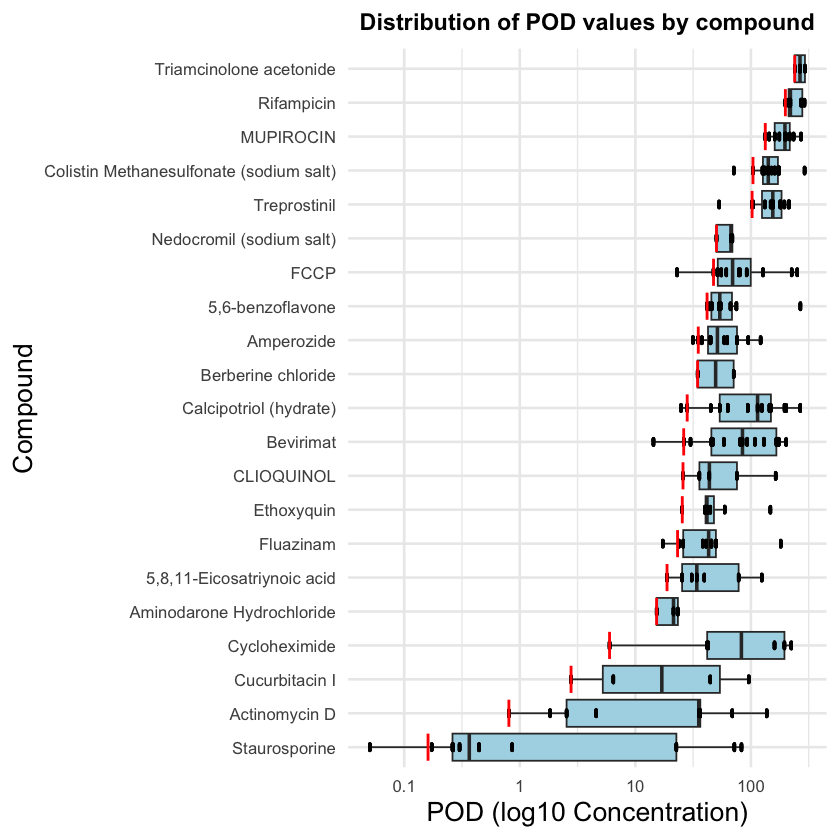

In [ ]:
# boxplot of the BMD value per compound

compound_categories <- df %>%
  select(Metadata_Compound) %>%
  distinct() %>%
  rename(compound = Metadata_Compound)

pod_summary <- final_df_md %>%
  group_by(compound) %>%
  summarise(
    pod_10th_percentile_cp = quantile(Concentration, probs = 0.10, na.rm = TRUE),
    nb_features = n_distinct(protein)
  ) %>%
  left_join(compound_categories, by = "compound") %>%
  arrange(desc(nb_features))


df_bmd <- final_df_md %>% 
  filter(!is.na(Concentration))

compound_order <- pod_summary %>%
  arrange(pod_10th_percentile_cp) %>%
  pull(compound)


df_bmd$compound <- factor(df_bmd$compound, levels = compound_order)


pod_summary$compound <- factor(pod_summary$compound, levels = compound_order)

ggplot(df_bmd, aes(x = log10(Concentration), y = compound)) +
  geom_boxplot(fill = "lightblue", outlier.shape = NA, width = 0.8) +
  geom_jitter(width = 0, height = 0.1, alpha = 0.3, color = "black", size = 0.3) +
  geom_segment(
    data = pod_summary,
    aes(
      x = log10(pod_10th_percentile_cp),
      xend = log10(pod_10th_percentile_cp),
      y = as.numeric(compound) - 0.4,
      yend = as.numeric(compound) + 0.4
    ),
    color = "red",
    size = 0.8,
    inherit.aes = FALSE
  ) +
  labs(
    title = "Distribution of POD values by compound",
    x = "POD (log10 Concentration)",
    y = "Compound"
  ) +
  scale_x_continuous(
    breaks = log10(c(0.001, 0.01, 0.1, 1, 10, 100)),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100")
  ) +
  theme_minimal(base_size = 16) +
  theme(
    axis.text.y = element_text(size = 10),
    axis.text.x = element_text(size = 10),
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold")
  )


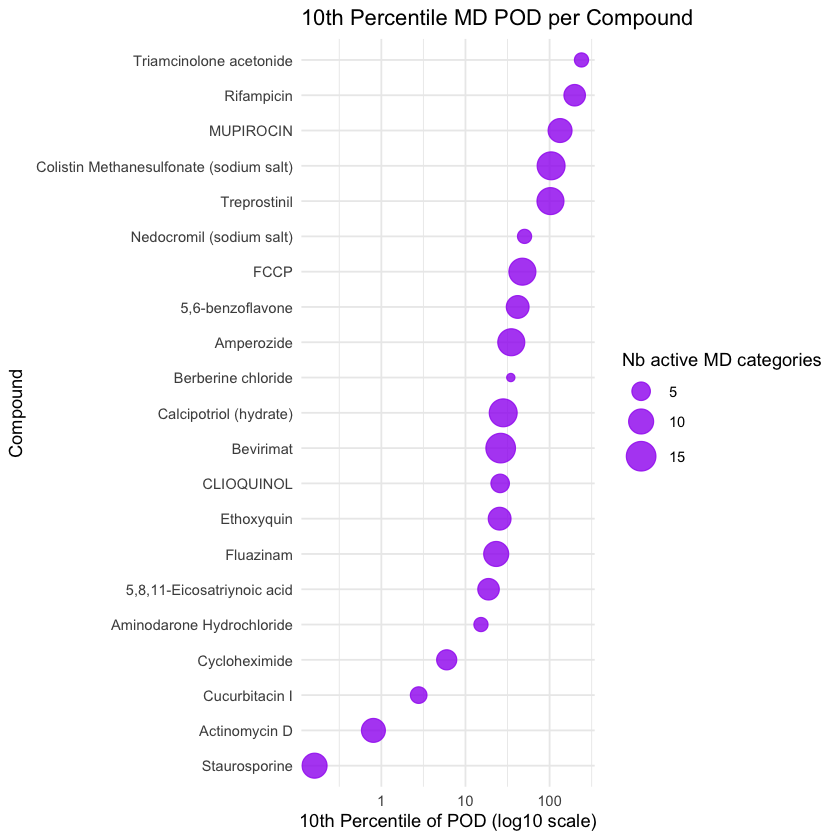

In [16]:
### Calculate the 10th percentile of BMD for each compound across all protein bmds 

compound_categories <- df %>%
  select(Metadata_Compound) %>%
  distinct() %>%
  rename(compound = Metadata_Compound)

pod_summary <- final_df_md %>%
  group_by(compound) %>%
  summarise(
    pod_10th_percentile_MD = quantile(Concentration, probs = 0.10, na.rm = TRUE),
    nb_category_MD = n_distinct(protein)
  ) %>%
  left_join(compound_categories, by = "compound") %>%
  arrange(desc(nb_category_MD))


#print(pod_summary, n=Inf)

ggplot(pod_summary, aes(x = pod_10th_percentile_MD, y = reorder(compound, pod_10th_percentile_MD))) +
  geom_point(aes(size = nb_category_MD), color = "purple", alpha = 0.8) +
  scale_x_continuous(
    trans = "log10",
    breaks = c(0.001, 0.01, 0.1, 1, 10, 100),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100")
  ) +
  scale_size_continuous(range = c(2, 8)) + 
  labs(title = "10th Percentile MD POD per Compound",
       x = "10th Percentile of POD (log10 scale)",
       y = "Compound",
       size = "Nb active MD categories") +
  theme_minimal()



In [17]:
## fusioning the results of proteomic data and MD distance from CP data


bmd_table= read.csv('./outputs/proteomic_bmd_dose_results_10th_perc.csv', sep= ',')

merged_table <- merge(pod_summary, bmd_table, by = "compound", all = TRUE)

#print(merged_table)

write.csv(merged_table, "./outputs/proteomic_and_MD_10th_perc.csv", row.names = FALSE)

write.csv(final_df_md, "./outputs/results_MD_CP_data.csv", row.names = FALSE)